Лабораторна робота №4

Завантажити датасет
https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

Створити модель CNN і претреновану модель VGG 16
для класифікації зображень з використанням Pytorch
Вивести матрицю плутанини, криві навчання, візуалізацію розпізнавання.
Написати висновки.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cd  /content//drive/MyDrive/cards/train && rm -rf `find -type d -name .ipynb_checkpoints`
!cd  /content//drive/MyDrive/cards/valid && rm -rf `find -type d -name .ipynb_checkpoints`
!cd  /content//drive/MyDrive/cards/test && rm -rf `find -type d -name .ipynb_checkpoints`

In [4]:
train_dir = '/content/drive/MyDrive/cards/train'
val_dir = '/content/drive/MyDrive/cards/valid'
test_dir ='/content/drive/MyDrive/cards/test'

In [5]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
train_dataset = datasets.ImageFolder(train_dir, transform=transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
def imshow(images, labels, class_names):
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()

In [9]:
class_names = train_loader.dataset.classes

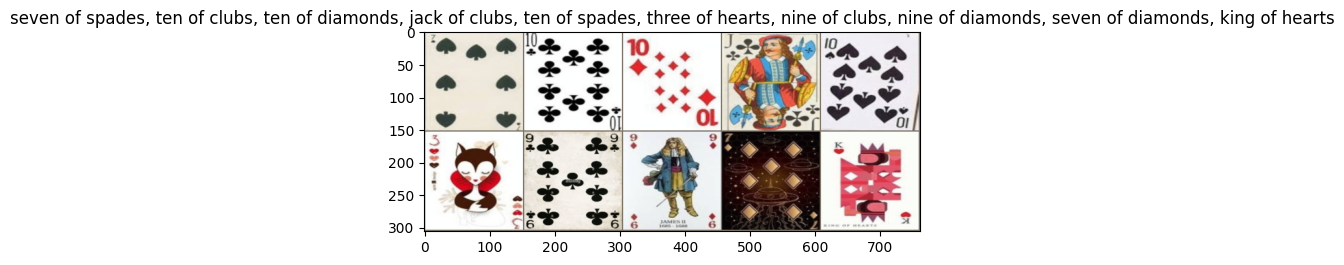

In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(make_grid(images[:10], nrow=5), labels[:10], class_names)

In [11]:
print(f"Кількість класів: {len(train_dataset.classes)}")
print(f"Класи: {train_dataset.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset.samples:
    class_counts[train_dataset.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 53
Класи: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']
Розмір тренув

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=36):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self._initialize_fc_layer()

        self.fc1 = nn.Linear(self.fc1_in_features, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _initialize_fc_layer(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self._forward_conv_layers(dummy_input)
            self.fc1_in_features = dummy_output.numel()

    def _forward_conv_layers(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(-1, self.fc1_in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
model = SimpleCNN(num_classes=36)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Налаштування тренувального процесу
num_epochs = 7
best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валідація
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pth')

  0%|          | 0/239 [00:10<?, ?it/s]


IndexError: Target 51 is out of bounds.

In [16]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [17]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [18]:
model.load_state_dict(torch.load('best_model_1.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

FileNotFoundError: [Errno 2] No such file or directory: 'best_model_1.pth'

In [19]:
class_names = train_dataset.classes

# Обчислення точності та F1
test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Створення матриці помилок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

ZeroDivisionError: division by zero

In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
visualize_predictions(model, test_loader, train_dataset.classes, 15)

Висновок: У данному завданні було розглянуто використання та побудову моделей для аналізу класифікації зображень з використанням Pytorch. Бібліотека показала свою високу здатність до швидкого та точного аналізу зображень. Виконане завдання було надан через доступ до Google Colab та завантажене на Гітхаб.